In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import netCDF4 as nc

import os
import sys
from pathlib import Path

os.chdir(Path(sys.path[0]).parent)
import modules.utils as utils

import torch
import torch.nn as nn
import torch.nn.functional as F

## Prepare the data

In [2]:
L = 32
Directory = f"data/L_{L}"

variables=['u', 'v', 'w', 'theta', 's', 'tke', 'wtheta']
nz=376

len_samples = nz*len(variables)
len_in = nz*(len(variables)-1)
len_out = nz

### Split train test ds

In [3]:
times = [i for i in range(1,63)]
perm = np.random.permutation(times)
train_times = perm[:int(0.8*len(times))]
test_times = perm[int(0.8*len(times)):]

In [4]:
#init train ds
path_data = Directory+f'/input_ds_for_simple_nn_T{train_times[0]}_L_{L}.nc'
nc_init = nc.Dataset(path_data)
train_ds = nc_init['sample'][:].filled()

for t in train_times[1:]:
    path_data = Directory+f'/input_ds_for_simple_nn_T{t}_L_{L}.nc'
    nc_init = nc.Dataset(path_data)
    time_ds = nc_init['sample'][:].filled()
    train_ds = np.concatenate((train_ds, time_ds), axis=0)

In [5]:
#init test ds
path_data = Directory+f'/input_ds_for_simple_nn_T{test_times[0]}_L_{L}.nc'
nc_init = nc.Dataset(path_data)
test_ds = nc_init['sample'][:].filled()

for t in test_times[1:]:
    path_data = Directory+f'/input_ds_for_simple_nn_T{t}_L_{L}.nc'
    nc_init = nc.Dataset(path_data)
    time_ds = nc_init['sample'][:].filled()
    test_ds = np.concatenate((test_ds, time_ds), axis=0)

In [6]:
# split train and test ds in input-output datasets
input_train, output_train, input_val, output_val = train_ds[:,:len_in], train_ds[:,len_in:], test_ds[:,:len_in], test_ds[:,len_in:]
input_train.shape

(12544, 2256)

## Define the model

In [7]:
class DNN(nn.Module):
    def __init__(self, batch_size, input_size, output_size, drop_prob1=0.3, drop_prob2=0.4, drop_prob3=0.5, hidden_size1=512, hidden_size2=256, hidden_size3=256):
        super(DNN, self).__init__()
        self.regression = nn.Sequential(nn.Linear(input_size, hidden_size1),
                                        nn.ReLU(),
                                        nn.Dropout(drop_prob1),
                                        nn.Linear(hidden_size1, hidden_size2),
                                        nn.ReLU(),
                                        nn.Dropout(drop_prob2),
                                        nn.Linear(hidden_size2, hidden_size3),
                                        nn.ReLU(),
                                        nn.Dropout(drop_prob3),
                                        nn.Linear(hidden_size3, output_size)
                                        )
        self.drop_prob1 = drop_prob1
        self.drop_prob2 = drop_prob2
        self.drop_prob3 = drop_prob3
        self.batch_size = batch_size
        self.input_shape = input_size
        self.output_shape = output_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.hidden_size3 = hidden_size3

    
    def forward(self, x):
        return self.regression(x)

In [8]:
learning_rate = 0.001
batch_size = 32
nb_epochs = 20
train_losses=[]
test_losses=[]
n_batches = input_train.shape[0]//batch_size

In [9]:
model = DNN(batch_size=batch_size,input_size=len_in,output_size=len_out)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# train : convert numpy array to torch tensor
input = torch.from_numpy(input_train).float()
output = torch.from_numpy(output_train).float()

# test : convert numpy array to torch tensor
input_test = torch.from_numpy(input_val).float()
output_test = torch.from_numpy(output_val).float()

## Train and test the model

In [45]:
# train the model
#model.train()

for epoch in trange(nb_epochs, leave=False):
    model.train()
    tot_losses=0
    indexes_arr = np.random.permutation(input_train.shape[0]).reshape(-1, batch_size)
    for i_batch in indexes_arr:
        input_batch = input[i_batch,:]
        output_batch = output[i_batch,:]
        optimizer.zero_grad()
        # forward pass
        output_pred = model(input_batch)
        # compute loss
        loss = F.mse_loss(output_pred, output_batch, reduction='sum')
        tot_losses += loss.item()
        # backward pass
        loss.backward()
        optimizer.step()
    train_losses.append(tot_losses/n_batches)
    
    model.eval()
    # prediction
    output_pred = model(input_test)
    # compute loss
    test_loss = F.mse_loss(output_pred, output_test, reduction='sum') / (input_test.shape[0]//batch_size)
    test_losses.append(test_loss)
    
    if (epoch+1)%5==0 or epoch==0:
        print('Epoch [{}/{}], Loss: {:.6f}'.format(epoch+1, nb_epochs, tot_losses/n_batches))


  5%|▌         | 1/20 [00:06<01:54,  6.03s/it]

Epoch [1/20], Loss: 21.390850



 25%|██▌       | 5/20 [01:31<04:41, 18.79s/it]

Epoch [5/20], Loss: 0.263473



 50%|█████     | 10/20 [03:32<03:53, 23.30s/it]

Epoch [10/20], Loss: 0.261431



 75%|███████▌  | 15/20 [05:34<02:01, 24.33s/it]

Epoch [15/20], Loss: 0.266250



100%|██████████| 20/20 [07:38<00:00, 24.73s/it]
                                               

Epoch [20/20], Loss: 0.262299


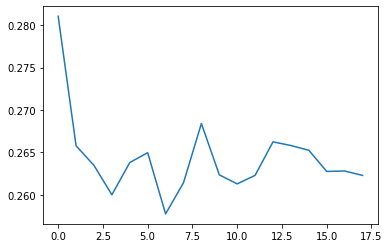

In [50]:
plt.plot(train_losses[2:])

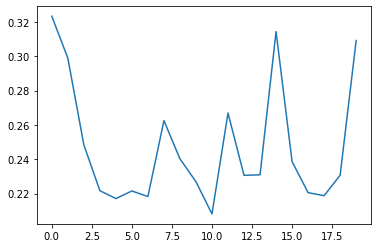

In [51]:
plt.plot(test_losses)

In [13]:
# test the model

# convert numpy array to torch tensor
input_test = torch.from_numpy(input_val).float()
output_test = torch.from_numpy(output_val).float()

model.eval()
# prediction
output_pred = model(input_test)
# compute loss
loss = F.mse_loss(output_pred, output_test, reduction='sum') / (input_test.shape[0]//batch_size)

print('Test loss: {:.6f}'.format(loss))

Test loss: 0.321151


In [52]:
torch.save(model.state_dict(), 'explo/simple_dnn')

## Use previous models

In [10]:
model_load = DNN(batch_size=batch_size,input_size=len_in,output_size=len_out)
model_load.load_state_dict(torch.load('explo/models/simple_dnn7prime'))
model_load.eval()

DNN(
  (regression): Sequential(
    (0): Linear(in_features=2256, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=256, out_features=376, bias=True)
  )
)

In [11]:
# convert numpy array to torch tensor
input_test = torch.from_numpy(input_val).float()
output_test = torch.from_numpy(output_val).float()
tot_losses=0

model_load.eval()
# prediction
output_pred = model_load(input_test)
# compute loss
loss = F.mse_loss(output_pred, output_test, reduction='sum') / (input_test.shape[0]//batch_size)

print('Test loss: {:.6f}'.format(loss))

Test loss: 0.301028


In [12]:
output_test.shape

torch.Size([3328, 376])

Plot the coarse grained heat flux (both predicted and real) from the reconstructed output and objective of the DNN.

t = 12


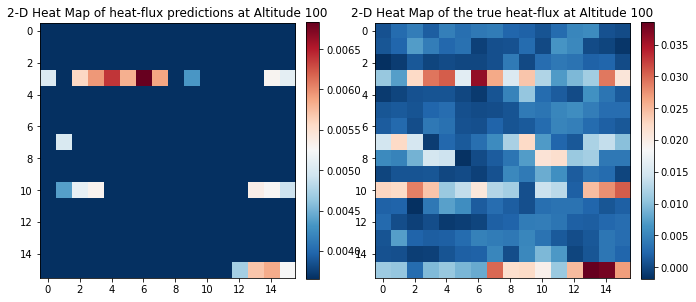

0.0068362965 0.0036564127 0.0061089406


In [13]:
t = 0
z=100
largeur = int(512/L)
pred_ds = output_pred[t*largeur**2:(t+1)*largeur**2,:].cpu().detach().numpy()
true_ds = output_test[t*largeur**2:(t+1)*largeur**2,:].cpu().detach().numpy()

#print(pred_ds)
print('t =',test_times[t])
utils.plot_output(pred_ds,true_ds,L,z,color='RdBu_r')

print(pred_ds[:,z].max(),pred_ds[:,z].min(), true_ds[:,z].mean())

Plot the coarse grained heat flux from Adrien's written nc files.

temperature mean,min,max: -4.382540337577456e-14 -0.027927474975630244 0.04308522033687093
wtheta mean,min,max : 0.0061089406482774606 -0.0017906517220525023 0.0385702809333624


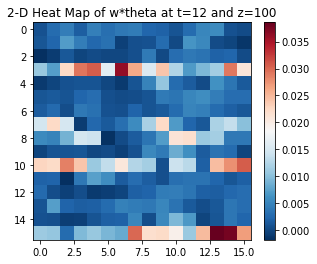

In [14]:
path_data = Directory+f'/input_ds_for_simple_nn_T{test_times[t]}_L_{L}.nc'
nc_init = nc.Dataset(path_data)
test_ds = nc_init['sample'][:].filled()[:,-len_out+z].reshape(16,16)
theta_ds = nc_init['sample'][:].filled()[:,3*len_out+z].reshape(16,16)
print('temperature mean,min,max:', theta_ds.mean(),theta_ds.min(),theta_ds.max())
print('wtheta mean,min,max :',test_ds.mean(),test_ds.min(),test_ds.max())
im = plt.imshow(test_ds , cmap = 'RdBu_r' , interpolation = 'nearest' )
plt.colorbar(im, orientation='vertical', fraction=0.046, pad=0.04)
plt.title(f"2-D Heat Map of w*theta at t={test_times[t]} and z={z}")
plt.show()

## Check coherence

Plot the coarse grained heat flux directly from Sara's high res simulation

Use plot_alt_val cells 2 and 3.

In [15]:

nc_init = nc.Dataset(f"/glade/scratch/sshamekh/LES_512_ug16wtspt01_data/wxy{z//2}_T{test_times[t]}.nc")
#print(nc_init[f'wxy{z//2}'][:].filled()[:,:,:,:].shape)
w_arr = nc_init[f'wxy{z//2}'][:].filled()[0,z%2,:,:]
print('w fluctuations mean, min, max :', w_arr.mean(),w_arr.min(),w_arr.max())


nc_init = nc.Dataset(f"/glade/scratch/sshamekh/LES_512_ug16wtspt01_data/thetaxy{z//2}_T{test_times[t]}.nc")
theta_arr = nc_init[f'thetaxy{z//2}'][:].filled()[0,z%2,:,:]
print('theta mean, min, max :', theta_arr.mean(),theta_arr.min(),theta_arr.max())
theta_arr -= theta_arr.mean()
print('theta fluctuations mean, min, max :', theta_arr.mean(),theta_arr.min(),theta_arr.max())

wtheta = w_arr*theta_arr
print('wtheta fluctuations mean, min, max :',wtheta.mean(),wtheta.min(),wtheta.max())

fig,axes = plt.subplots(1,2,figsize=(13,5))

im0 = axes[0].imshow(wtheta , cmap = 'RdBu_r' , interpolation = 'nearest' )
fig.colorbar(im0, ax=axes[0], orientation='vertical', fraction=0.046, pad=0.04)
axes[0].set_title(f"2-D Heat Map of w*theta at t={test_times[t]} and z={z}")

coarse_wtheta = utils.coarse_array(wtheta.reshape(1,1,512,512),L).reshape(16,16)
im1 = axes[1].imshow(coarse_wtheta , cmap = 'RdBu_r' , interpolation = 'nearest')
fig.colorbar(im1, ax=axes[1], orientation='vertical', fraction=0.046, pad=0.04)
axes[1].set_title(f"2-D coarse grained Heat Map of w*theta at t={test_times[t]} and z={z}")

plt.show()

FileNotFoundError: [Errno 2] No such file or directory: b'/glade/scratch/sshamekh/LES_512_ug16wtspt01_data/wxy50_T12.nc'

## Define baseline model

Baseline model : $\overline{w*\theta} \simeq \overline{w}*\overline{\theta}$

Comparison of objective heat flux, baseline heat flux and element wise difference of them.

In [16]:
path_data = Directory+f'/input_ds_for_simple_nn_T{test_times[t]}_L_{L}.nc'
nc_init = nc.Dataset(path_data)
time_ds = nc_init['sample'][:].filled()
time_ds[:,len_in:][:,z].shape

(256,)

12
Mean,min,max temperature fluctuation : -4.382540337577456e-14 -0.027927474975630244 0.04308522033687093
Mean,min,max true heat flux : 0.0061089406482774606 -0.0017906517220525023 0.0385702809333624
Mean,min,max baseline heat flux : 0.003207686179465062 -0.0055713141087298 0.031130684418413466


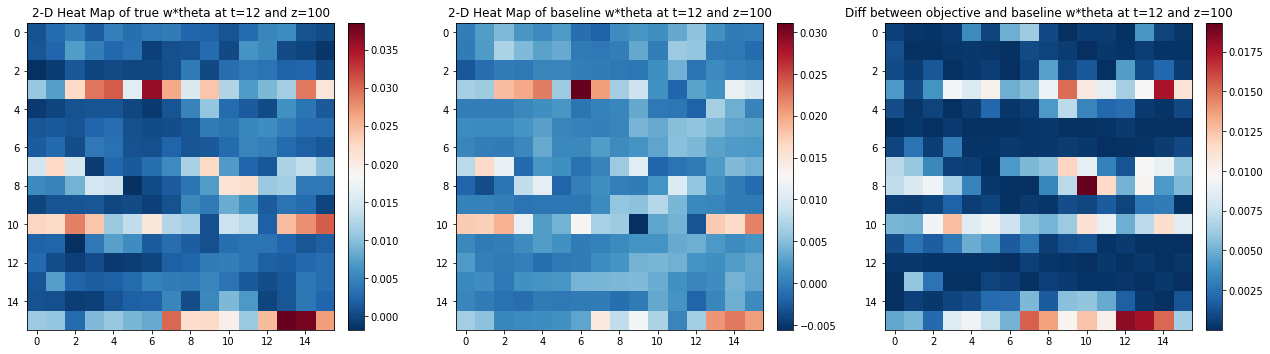

In [23]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

t=0
lz=376
z=100     # equivalent to z=18 : first alt is 18
print(test_times[t])
path_data = Directory+f'/input_ds_for_simple_nn_T{test_times[t]}_L_32.nc'  #'data/L_32_new/input_ds_for_simple_nn_T10_L_32.nc'
nc_init = nc.Dataset(path_data)
true_heat_flux = nc_init[f'sample'][:].filled()[:,-len_out:][:,z].reshape(16,16)        # -len_out because : last len_out values are wtheta, z is wtheta at alt z

w_arr = nc_init[f'sample'][:].filled()[:,2*len_out:][:,z].reshape(16,16)        # variables are [u,v,w,theta,s,tka,wtheta] so 2*len_out is w
theta_arr = nc_init[f'sample'][:].filled()[:,3*len_out:][:,z].reshape(16,16)    # variables are [u,v,w,theta,s,tka,wtheta] so 3*len_out is theta
baseline_heat_flux = w_arr*theta_arr

print('Mean,min,max temperature fluctuation :',theta_arr.mean(),theta_arr.min(),theta_arr.max())
print('Mean,min,max true heat flux :',true_heat_flux.mean(),true_heat_flux.min(),true_heat_flux.max())
print('Mean,min,max baseline heat flux :',baseline_heat_flux.mean(),baseline_heat_flux.min(),baseline_heat_flux.max())

fig,axes = plt.subplots(1,3,figsize=(18,5))

im0 = axes[0].imshow(true_heat_flux , cmap = 'RdBu_r' , interpolation = 'nearest' )
fig.colorbar(im0, ax=axes[0], orientation='vertical', fraction=0.046, pad=0.04)
axes[0].set_title(f"2-D Heat Map of true w*theta at t={test_times[t]} and z={z}")

im1 = axes[1].imshow(baseline_heat_flux , cmap = 'RdBu_r' , interpolation = 'nearest' )
fig.colorbar(im1, ax=axes[1], orientation='vertical', fraction=0.046, pad=0.04)
axes[1].set_title(f"2-D Heat Map of baseline w*theta at t={test_times[t]} and z={z}")

im2 = axes[2].imshow(np.abs(true_heat_flux - baseline_heat_flux) , cmap = 'RdBu_r' , interpolation = 'nearest' )
fig.colorbar(im2, ax=axes[2], orientation='vertical', fraction=0.046, pad=0.04)
axes[2].set_title(f"Diff between objective and baseline w*theta at t={test_times[t]} and z={z}")

fig.tight_layout()
plt.show()

Problem : with $\theta$ and not $\theta'$, the baseline seems to be way closer to the objective than NN.

Normal vu que on utilise $\theta$ et non pas $\theta'$ donc on a $\theta \simeq 293K$ en permanence. On peut donc le considérer comme constant et $\overline{\theta} = \theta$, d'où $$\overline{w*\theta} = \overline{w*\overline{\theta}} =\overline{w}*\overline{\theta}$$

-> il faut considérer $\theta'$

Si on considère $\theta'$, on remarque que le baseline model approxime bien le flux de chaleur sur les zones où il n'y a quasi pas de flux (grandes zones) et mal sur les zones de fort flux (petites zones qui sont donc moyennées avec ce qui les entoure).

-> On peut faire mieux.

## Compare model and baseline

baseline loss

In [16]:
loss = 0
for i in range(16):
    for j in range(16):
        loss += (true_heat_flux[i,j] - baseline_heat_flux[i,j])**2
loss

1.4567439904702952e-07